# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
#supress alll warings
import warnings
warnings.filterwarnings("ignore")

### Loading the parkinsons dataset and getting to know the dataset

In [3]:
# Load the Parkinson's dataset
parkinsons_data = pd.read_csv('E:/python/internship/parkinsons.csv')  # Replace with the correct path to your dataset

# Number of rows and columns in this dataset
print("Shape of the dataset:", parkinsons_data.shape)

# Getting the statistical measures of the data
print("Statistical Summary:\n", parkinsons_data.describe())

# Distribution of the target column (assuming the target column is 'status')
print("Target column value counts:\n", parkinsons_data['status'].value_counts())  # Replace 'status' with your target column name


# Separating the data and labels
X = parkinsons_data.drop(columns='status', axis=1)  # Replace 'status' with your target column name
y = parkinsons_data['status']  # Replace 'status' with your target column name

# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

# Print the shapes of the datasets
print("Shapes of datasets:\n")
print("Features (X):", X.shape)
print("Training Features (X_train):", X_train.shape)
print("Testing Features (X_test):", X_test.shape)


Shape of the dataset: (195, 24)
Statistical Summary:
        MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.00

### PERFORM DATA CLEANING AND HANDLE MISSING VALUES

In [4]:

# Check for missing values in the dataset
missing_values = parkinsons_data.isnull().sum()

# Check for invalid values (e.g., zero values in non-zero fields)
invalid_values_summary = (parkinsons_data == 0).sum()

missing_values, invalid_values_summary


(name                0
 MDVP:Fo(Hz)         0
 MDVP:Fhi(Hz)        0
 MDVP:Flo(Hz)        0
 MDVP:Jitter(%)      0
 MDVP:Jitter(Abs)    0
 MDVP:RAP            0
 MDVP:PPQ            0
 Jitter:DDP          0
 MDVP:Shimmer        0
 MDVP:Shimmer(dB)    0
 Shimmer:APQ3        0
 Shimmer:APQ5        0
 MDVP:APQ            0
 Shimmer:DDA         0
 NHR                 0
 HNR                 0
 status              0
 RPDE                0
 DFA                 0
 spread1             0
 spread2             0
 D2                  0
 PPE                 0
 dtype: int64,
 name                 0
 MDVP:Fo(Hz)          0
 MDVP:Fhi(Hz)         0
 MDVP:Flo(Hz)         0
 MDVP:Jitter(%)       0
 MDVP:Jitter(Abs)     0
 MDVP:RAP             0
 MDVP:PPQ             0
 Jitter:DDP           0
 MDVP:Shimmer         0
 MDVP:Shimmer(dB)     0
 Shimmer:APQ3         0
 Shimmer:APQ5         0
 MDVP:APQ             0
 Shimmer:DDA          0
 NHR                  0
 HNR                  0
 status              48
 

In [5]:
# Inspect column names
print("Columns in the dataset:\n", parkinsons_data.columns)

# Compare mean values for each feature by target (excluding non-numeric columns)
numeric_columns = parkinsons_data.select_dtypes(include=['number']).columns
grouped = parkinsons_data.groupby('status')[numeric_columns].mean()
print("Mean values grouped by target:\n", grouped)

# Replace invalid zero values with the mean for specific numeric columns
columns_to_impute = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)']  # Example columns

for column in columns_to_impute:
    if column in numeric_columns:
        mean_value = parkinsons_data[column].mean()
        parkinsons_data[column] = parkinsons_data[column].replace(0, mean_value)
    else:
        print(f"Column '{column}' not found in the dataset!")

# Verify if invalid values are replaced
zero_values_count = (parkinsons_data == 0).sum()
print("Number of zero values in each column:\n", zero_values_count)


Columns in the dataset:
 Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')
Mean values grouped by target:
         MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
status                                                            
0        181.937771    223.636750    145.207292        0.003866   
1        145.180762    188.441463    106.893558        0.006989   

        MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
status                                                                   
0               0.000023  0.001925  0.002056    0.005776      0.017615   
1               0.000051  0.003757  0.003900    0.011273      0.033658   

        MDVP:Shimme

### Perform EDA to understand the data.

Statistical Summary:
        MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540  

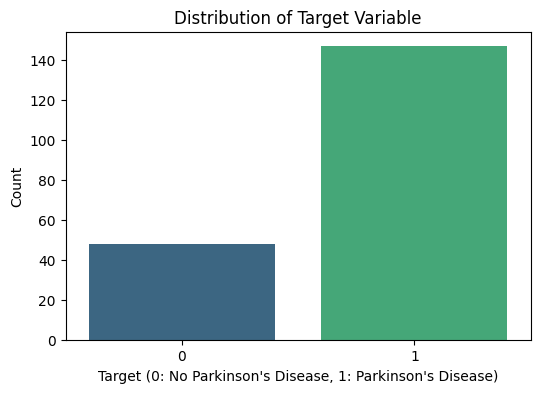

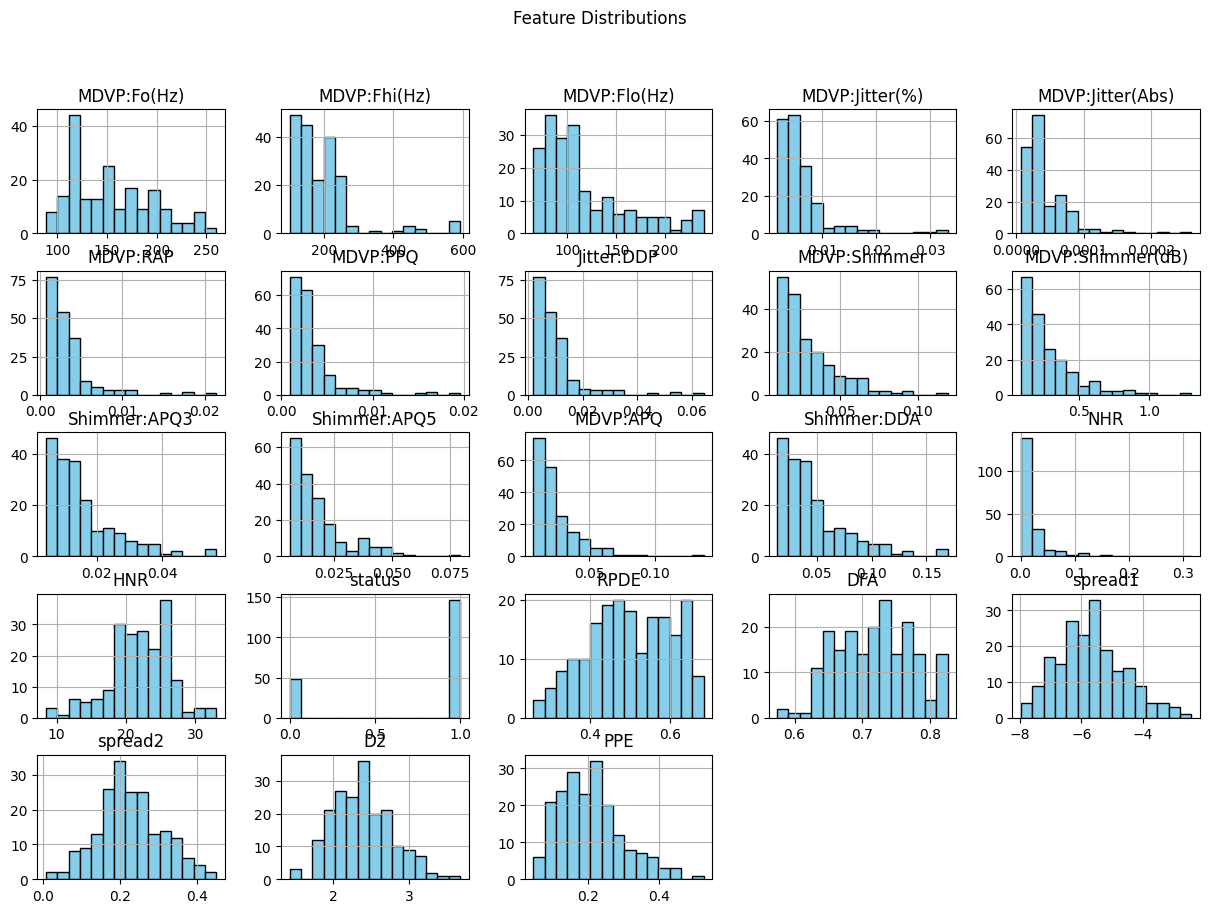

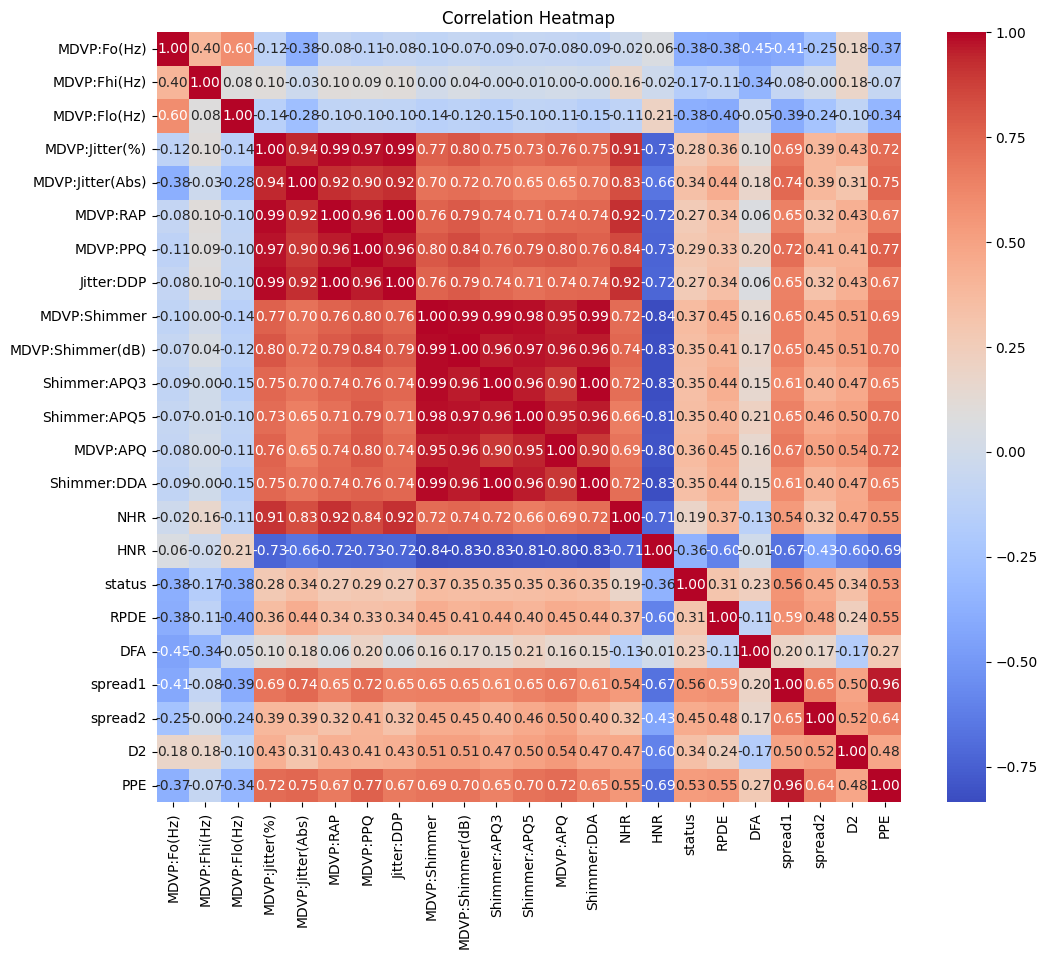

In [6]:
numeric_data = parkinsons_data.select_dtypes(include=['number'])

# Statistical summary
statistical_summary = numeric_data.describe()
print("Statistical Summary:\n", statistical_summary)

# Distribution of the target variable (status)
plt.figure(figsize=(6, 4))
sns.countplot(x='status', data=parkinsons_data, palette='viridis')  # Use 'status' as target
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: No Parkinson\'s Disease, 1: Parkinson\'s Disease)')
plt.ylabel('Count')
plt.show()

# Visualize distributions for all numerical features
numeric_data.hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Feature Distributions')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

### Split data into training, validation, and test sets

In [7]:
# Print the shape of the dataset
print("Dataset shape:", parkinsons_data.shape)

# Separate features and target variable
X = parkinsons_data.drop(columns='status')  # Features
y = parkinsons_data['status']  # Target variable

# First split: Training and temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: Validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verify the sizes of the splits
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Dataset shape: (195, 24)
Training set: (136, 23), Validation set: (29, 23), Test set: (30, 23)


###  MODEL and ACCURACY 

In [8]:
X = parkinsons_data.drop(columns=['name', 'status'])  # Features (exclude 'name' and target column 'status')
y = parkinsons_data['status']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM Classifier
classifier = svm.SVC(kernel='linear')

# Training the Support Vector Machine Classifier
classifier.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


In [9]:
# accuracy score on the training data
X_train_prediction = classifier.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train)
print('\nAccuracy score of the training data : ', training_data_accuracy)


# accuracy score on the test data
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print('Accuracy score of the test data : ', test_data_accuracy ,'\n')


Accuracy score of the training data :  0.8653846153846154
Accuracy score of the test data :  0.8717948717948718 



### Model Selection ,Building and Training 

In [10]:
# Initialize and train the SVM Classifier
svm_model = svm.SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
svm_predictions = svm_model.predict(X_test)

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print("Classification Report for SVM:\n", classification_report(y_test, svm_predictions))

SVM Accuracy: 0.8717948717948718
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.89      0.97      0.93        32

    accuracy                           0.87        39
   macro avg       0.82      0.70      0.74        39
weighted avg       0.86      0.87      0.86        39



In [11]:
# Define the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Perform Recursive Feature Elimination (RFE)
rfe_model = RFE(estimator=svm_model, n_features_to_select=5)
rfe_model.fit(X_train, y_train)

# Display selected features
selected_features = X.columns[rfe_model.support_]
print("Selected Features:", selected_features)

# Use only selected features for cross-validation
X_selected = X[selected_features]

# Apply Cross-Validation
cv_scores_svm = cross_val_score(svm_model, X_selected, y, cv=5, scoring='accuracy')

print("\nSVM Cross-Validation Accuracy:", cv_scores_svm.mean())

Selected Features: Index(['RPDE', 'DFA', 'spread1', 'spread2', 'D2'], dtype='object')

SVM Cross-Validation Accuracy: 0.8512820512820513


In [12]:
input_data = (197.07600,206.89600,192.05500,0.00289,0.00001,0.00166,0.00168,0.00498,0.01098,0.09700,0.00563,0.00680,0.00802,0.01689,0.00339,26.77500,0.422229,0.741367,-7.348300,0.177551,1.743867,0.085569)

# changing input data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the numpy array
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = classifier.predict(input_data_reshaped)
print(prediction)


if (prediction[0] == 0):
  print("The Person does not have Parkinsons Disease")

else:
  print("The Person has Parkinsons")


[0]
The Person does not have Parkinsons Disease


In [13]:

import pickle
filename = 'parkinsons_model.sav'
pickle.dump(classifier, open(filename, 'wb'))
# loading the saved model
loaded_model = pickle.load(open('parkinsons_model.sav', 'rb'))
for column in X.columns:
  print(column)

MDVP:Fo(Hz)
MDVP:Fhi(Hz)
MDVP:Flo(Hz)
MDVP:Jitter(%)
MDVP:Jitter(Abs)
MDVP:RAP
MDVP:PPQ
Jitter:DDP
MDVP:Shimmer
MDVP:Shimmer(dB)
Shimmer:APQ3
Shimmer:APQ5
MDVP:APQ
Shimmer:DDA
NHR
HNR
RPDE
DFA
spread1
spread2
D2
PPE
